In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import shutil

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:

DATAPATH = '/content/drive/My Drive/Face Mask/data/'
MASKPATH = '/content/drive/My Drive/Face Mask/data/with_mask/'
NOMASKPATH = '/content/drive/My Drive/Face Mask/data/without_mask/'
TESTPATH = '/content/drive/My Drive/Face Mask/testdata'

In [69]:
def view(pth):
    images = list()
    for img in random.sample(os.listdir(pth),9):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
    for row in range(3):
        for col in range(3):
            ax[row,col].imshow(cv2.imread(os.path.join(pth,images[i])))
            i+=1

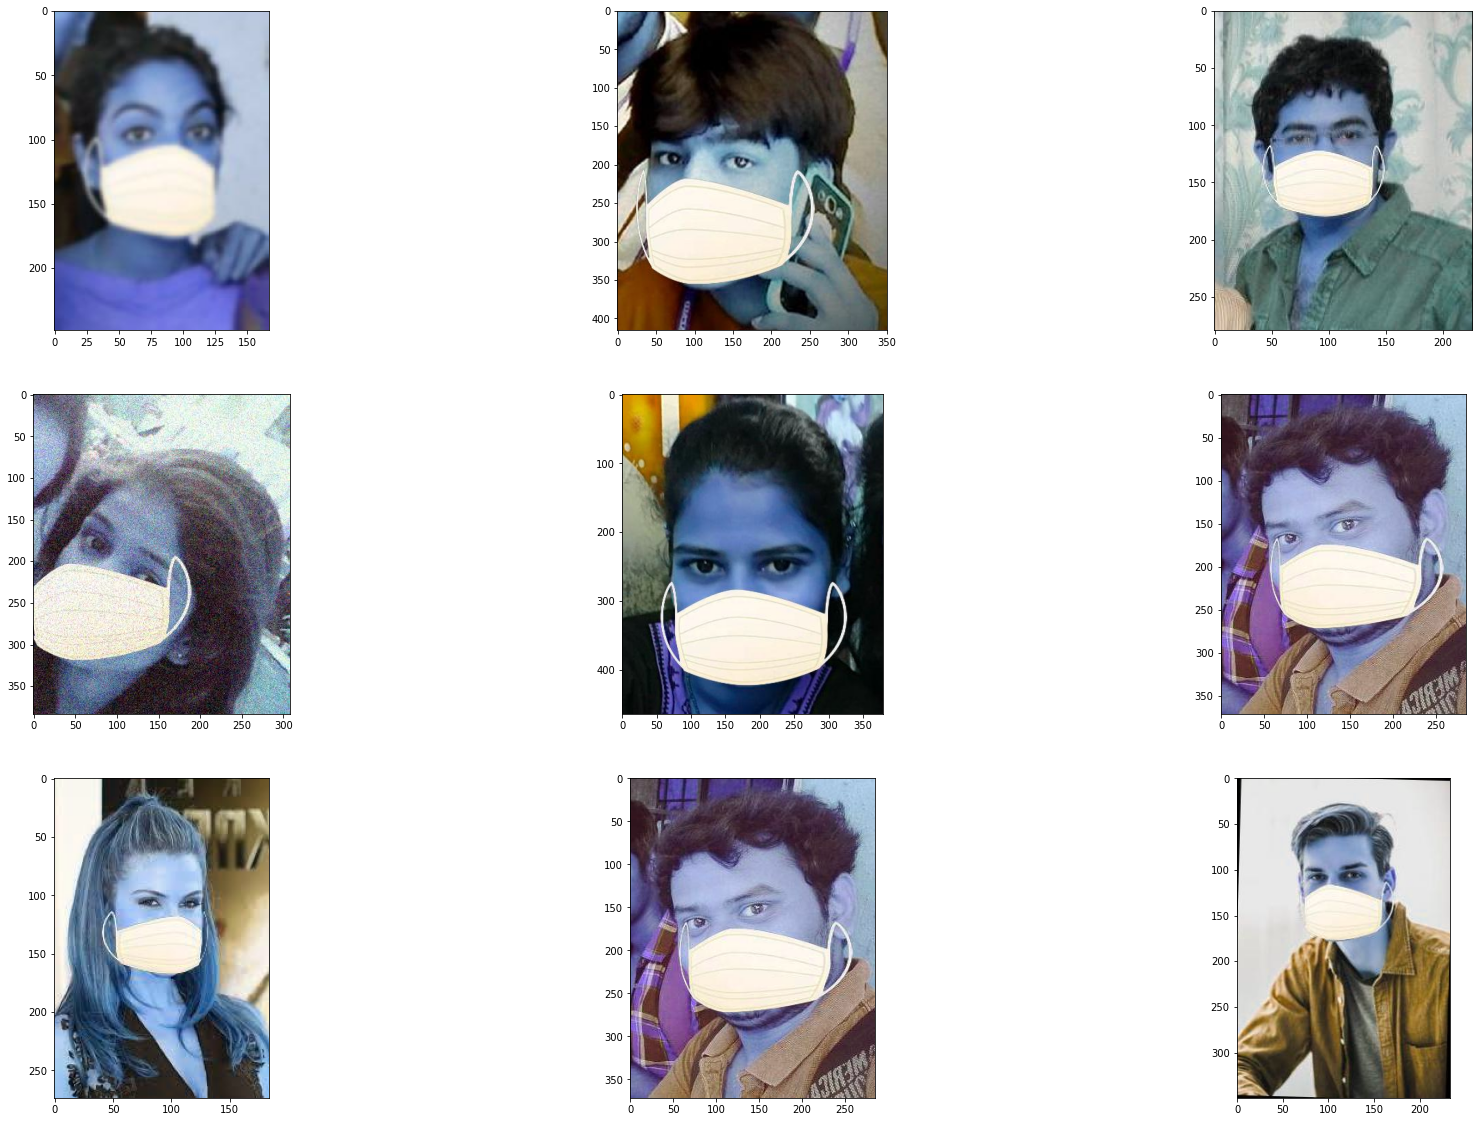

In [70]:
view(MASKPATH)

In [71]:

fig = go.Figure(
    data=[go.Pie(labels=['WITHMASK','WITHOUTMASK'], 
        values=[len(os.listdir(MASKPATH)),len(os.listdir(NOMASKPATH))])
    ])
fig.show()

In [72]:
os.mkdir(TESTPATH)
os.mkdir(os.path.join(TESTPATH,'with_mask'))
os.mkdir(os.path.join(TESTPATH,'without_mask'))

In [73]:
def getTest(pth):
    dataSplit = int(np.ceil(len(os.listdir(pth))*0.02))
    for img in os.listdir(pth)[-dataSplit:]:
        shutil.move(os.path.join(pth,img), os.path.join('testdata'.join(pth.split('data')),img))
getTest(MASKPATH)
getTest(NOMASKPATH)

In [74]:
len(os.listdir(MASKPATH)),len(os.listdir(NOMASKPATH))

(613, 618)

In [75]:
len(os.listdir(os.path.join(TESTPATH,'with_mask'))),len(os.listdir(os.path.join(TESTPATH,'without_mask')))

(13, 13)

**Preparing Data Input**

In [76]:
BATCH_SIZE = 32

In [77]:
trainGen = ImageDataGenerator(
    rescale= 1/255.,
    horizontal_flip=True,
    validation_split = 0.1
)

testGen = ImageDataGenerator(
    rescale= 1/255.,
)

In [78]:

train = trainGen.flow_from_directory(
    DATAPATH, 
    target_size=(224, 224),
    classes=['with_mask','without_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='training'
)

validation = trainGen.flow_from_directory(
    DATAPATH, 
    target_size=(224, 224),
    classes=['with_mask','without_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='validation'
)

test = testGen.flow_from_directory(
    TESTPATH, 
    target_size=(224, 224), 
    classes=['with_mask','without_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)

Found 1109 images belonging to 2 classes.
Found 122 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


**Building Model**

In [79]:
mob = MobileNetV2(
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet',
)
mob.trainable = False

In [34]:
model = Sequential()
model.add(mob)
model.add(GlobalAveragePooling2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 2,340,098
Trainable params: 82,114
Non-trainable params: 2,257,984
_________________________________________________________________


In [80]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['acc'])

In [81]:
checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

In [83]:

model_json = model.to_json()
with open(r'/content/drive/My Drive/Face Mask/modle.json', 'w') as file:
    file.write(model_json)

In [82]:

hist = model.fit(
    train,
    epochs = 15,
    validation_data = validation,
    callbacks = [checkpoint]
)

Epoch 1/15
35/35 [==============================] - 52s 1s/step - loss: 9.2447e-04 - acc: 1.0000 - val_loss: 0.0158 - val_acc: 0.9836

Epoch 00001: val_loss improved from inf to 0.01575, saving model to model.h5
Epoch 2/15
35/35 [==============================] - 48s 1s/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0304 - val_acc: 0.9918

Epoch 00002: val_loss did not improve from 0.01575
Epoch 3/15
35/35 [==============================] - 49s 1s/step - loss: 0.0088 - acc: 0.9978 - val_loss: 0.1197 - val_acc: 0.9836

Epoch 00003: val_loss did not improve from 0.01575
Epoch 4/15
35/35 [==============================] - 50s 1s/step - loss: 0.0074 - acc: 0.9988 - val_loss: 0.0283 - val_acc: 0.9836

Epoch 00004: val_loss did not improve from 0.01575
Epoch 5/15
35/35 [==============================] - 49s 1s/step - loss: 0.0083 - acc: 0.9959 - val_loss: 0.0410 - val_acc: 0.9836

Epoch 00005: val_loss did not improve from 0.01575
Epoch 6/15
35/35 [==============================] - 48s 1s/s

In [38]:

model.evaluate(test)

1/1 [==============================] - 1s 1s/step - loss: 6.0422e-05 - acc: 1.0000


[6.042225504643284e-05, 1.0]